# Importing libraries

In [1]:
from sksurv.tree import SurvivalTree
from sksurv.datasets import load_gbsg2
from sklearn.model_selection import train_test_split
from sksurv.preprocessing import OneHotEncoder
from sksurv.metrics import integrated_brier_score
import numpy
import pandas as pd
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter
%pylab inline
figsize(12,6)

Populating the interactive namespace from numpy and matplotlib


# Loading dataset

In [2]:
X, y = load_gbsg2()
X.loc[:, "tgrade"] = X.loc[:, "tgrade"].map(len).astype(int)
Xt = OneHotEncoder().fit_transform(X)

In [3]:
X.columns

Index(['age', 'estrec', 'horTh', 'menostat', 'pnodes', 'progrec', 'tgrade',
       'tsize'],
      dtype='object')

In [5]:
df_y = pd.DataFrame(data={'time': [y[i][1] for i in range(len(y))], 'event': [y[i][0] for i in range(len(y))]})
df_y[:10].style.hide_index().highlight_min('event', color='lightgreen')

time,event
1814.000000,True
2018.000000,True
712.000000,True
1807.000000,True
772.000000,True
448.000000,True
2172.000000,False
2161.000000,False
471.000000,True
2014.000000,False


In [6]:
df = pd.concat([X, df_y], axis=1, join='inner')
df["event"] = df["event"].astype(int)
df.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize,time,event
0,70.0,66.0,no,Post,3.0,48.0,2,21.0,1814.0,1
1,56.0,77.0,yes,Post,7.0,61.0,2,12.0,2018.0,1
2,58.0,271.0,yes,Post,9.0,52.0,2,35.0,712.0,1
3,59.0,29.0,yes,Post,4.0,60.0,2,17.0,1807.0,1
4,73.0,65.0,no,Post,1.0,26.0,2,35.0,772.0,1


# Description of Data

In [23]:
print(f'Number of samples: {len(df_y)}')
print(f'Number of right censored samples: {len(df_y.query("event == False"))}')
print(f'Percentage of right censored samples: {100*len(df_y.query("event == False"))/len(df_y):.1f}%')

Number of samples: 686
Number of right censored samples: 387
Percentage of right censored samples: 56.4%


# Keplan Meier estimate and comparsion between cohorts

<AxesSubplot:xlabel='timeline'>

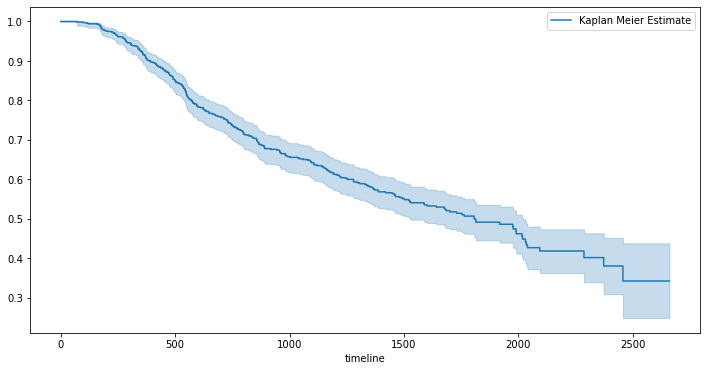

In [7]:
durations = df['time']
event_observed = df['event']
km = KaplanMeierFitter()

km.fit(durations, event_observed,label='Kaplan Meier Estimate')
km.plot()

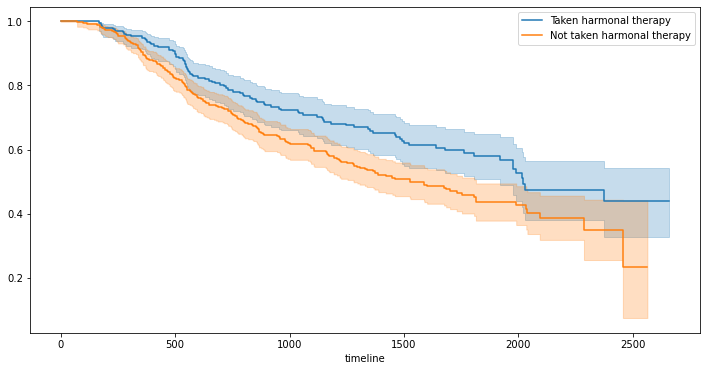

In [8]:
kmf = KaplanMeierFitter() 


T = df['time'] 
E = df['event']  


groups = df['horTh']           
ix1 = (groups == 'yes') 
ix2 = (groups == 'no')    

kmf.fit(T[ix1], E[ix1], label='Taken harmonal therapy')    
ax = kmf.plot()

kmf.fit(T[ix2], E[ix2], label='Not taken harmonal therapy')   
ax1 = kmf.plot(ax=ax)

<AxesSubplot:xlabel='timeline'>

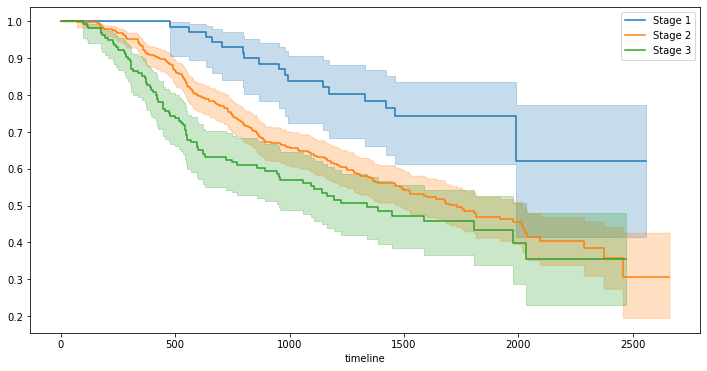

In [9]:
kmf = KaplanMeierFitter() 


T = df['time']     
E = df['event']    
groups = df['tgrade']             

ix1 = (groups == 1)   
ix2 = (groups == 2)         
ix3 = (groups == 3)         

kmf.fit(T[ix1], E[ix1], label='Stage 1')   
ax = kmf.plot()

kmf.fit(T[ix2], E[ix2], label='Stage 2')         
ax1 = kmf.plot(ax=ax)

kmf.fit(T[ix3], E[ix3], label='Stage 3')        
kmf.plot(ax=ax1)                                 

# Train test split

In [10]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)
times = numpy.arange(80, 2300)

# Calculating Integrated brier score

In [11]:
estimator = SurvivalTree().fit(X_train, y_train)
survs = estimator.predict_survival_function(X_test, return_array=False)
preds = numpy.asarray([[fn(t) for t in times] for fn in survs])
integrated_brier_score = integrated_brier_score(y_test, y_test, preds, times)
print("The integrated brier score is " + str(integrated_brier_score))

The integrated brier score is 0.24234122232807126


# Predicted Survival function using Survival trees

C:\Users\Aditi\anaconda3\lib\site-packages\sksurv\tree\tree.py:525: FutureWarning: predict_survival_function will return an array of StepFunction instances in 0.14. Use return_array=True to keep the old behavior.
  warnings.warn(


Text(0.5, 1.0, 'Survival Function')

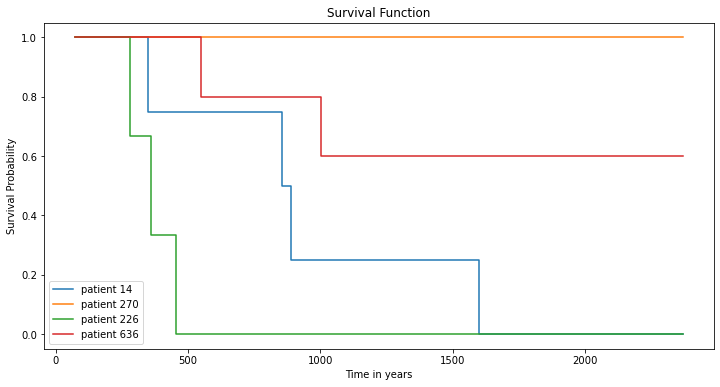

In [22]:
y_t = estimator.predict_survival_function(X_test.iloc[0:4])
eventTimes = survs[0].x
for i in range(len(y_t)):
    plt.step(eventTimes, y_t[i], where="post",label=f"patient {X_test.iloc[i].name}")

plt.xlabel("Time in years")
plt.ylabel("Survival Probability")
plt.legend()
plt.title('Survival Function')